In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import plotly as py
# import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
from itertools import product
import scipy as sp
from scipy.special import expit

from compton import expansion_parameter, expansion_parameter_transfer_cm, order_transition, coefficients
from compton import mass_proton, mass_neutron, omega_cm_from_lab, mass_pion, mass_delta

from os import path

from compton import create_observable_set
from compton import omega_lab_cusp
from compton import observables_unique
from compton import ref_scale
from compton import observables_name_map
from compton import setup_rc_params
from compton import dsg_label
from compton import compute_expansion_summation_matrix
from compton import expansion_parameter_phillips

%matplotlib inline

In [2]:
setup_rc_params()

In [3]:
kernel_kwargs = {
    ('dsg', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=4),
    ('1X', 'proton'): dict(std=0.4, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=8),
    ('1Z', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=12),
    ('2X', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=8),
    ('2Z', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=4),
    ('3', 'proton'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('Y', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('3Y', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=12),
    ('3Yp', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('1Xp', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=12),
    ('1Zp', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('2Xp', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[180], height=12),
    ('2Zp', 'proton'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0], height=4),
    #
    ('dsg', 'neutron'): dict(std=2, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=None),
    ('1X', 'neutron'): dict(std=0.4, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('1Z', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('2X', 'neutron'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('2Z', 'neutron'): dict(std=2, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=None),
    ('3', 'neutron'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('Y', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('3Y', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('3Yp', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('1Xp', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('1Zp', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('2Xp', 'neutron'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[180], height=None),
    ('2Zp', 'neutron'): dict(std=1.5, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0], height=None),
}

In [4]:
observables_name_inverse_map = {val: key for key, val in observables_name_map.items()}

In [5]:
df = pd.read_csv('../data/compton_observables_new.csv', index_col=False)
df['observable'] = df['observable'].replace(observables_name_map)
# observables_unique = df['observable'].unique()

obs_file = path.abspath('../data/polarisabilities-coefficient-table-for-all-observables_20191111_jam.csv')
df_ratio = pd.read_csv(obs_file, dtype={'observable': str})
df_ratio['observable'] = df_ratio['observable'].replace(observables_name_map)
df_ratio['nucleon'] = df_ratio['nucleon'].replace({'neutron': 'Neutron', 'proton': 'Proton'})

compton_obs = create_observable_set(df=df_ratio, cov_exp=0.)

# obs vals: crosssection, 1Xp, 1X, 1Zp, 1Z, 2Xp, 2X, 2Zp, 2Z, 3, 3Yp, 3Y, Y
obs_vals = [
    'crosssection', '1Xp', '1X', '1Zp', '1Z', '2Xp',
    '2X', '2Zp', '2Z', '3', '3Yp', '3Y', 'Y'
]
# obs_vals = observables_unique
# obs_vals = [
#     'crosssection'
# ]
systems = ['Neutron', 'Proton']
order_map = {0: 0, 2: 1, 3: -1, 4: 2}
orders = np.array([0, 2, 3, 4])

# heights = [
#     150, 4, 4, 4, 4, 10, 8, 4, 3, 4, 4, 8, 4
# ]
# heights_dict = {obs: height for obs, height in zip(obs_vals, heights)}

scale_ref = True


# def ref_scale(omega, omega_pi, height, width=50):
#     return 1 / ((omega - omega_pi)**2/width**2 + 1/(height-1)) + 1

In [6]:
df_dsg_ref = pd.read_csv('../data/yref-dsg.csv', index_col=False)
# df_dsg_ref['nucleon'] = df_dsg_ref['nucleon'].replace({'neutron': 'Neutron', 'proton': 'Proton'})

In [7]:
omega = df['omegalab [MeV]'].unique()
theta = df['thetalab [deg]'].unique()

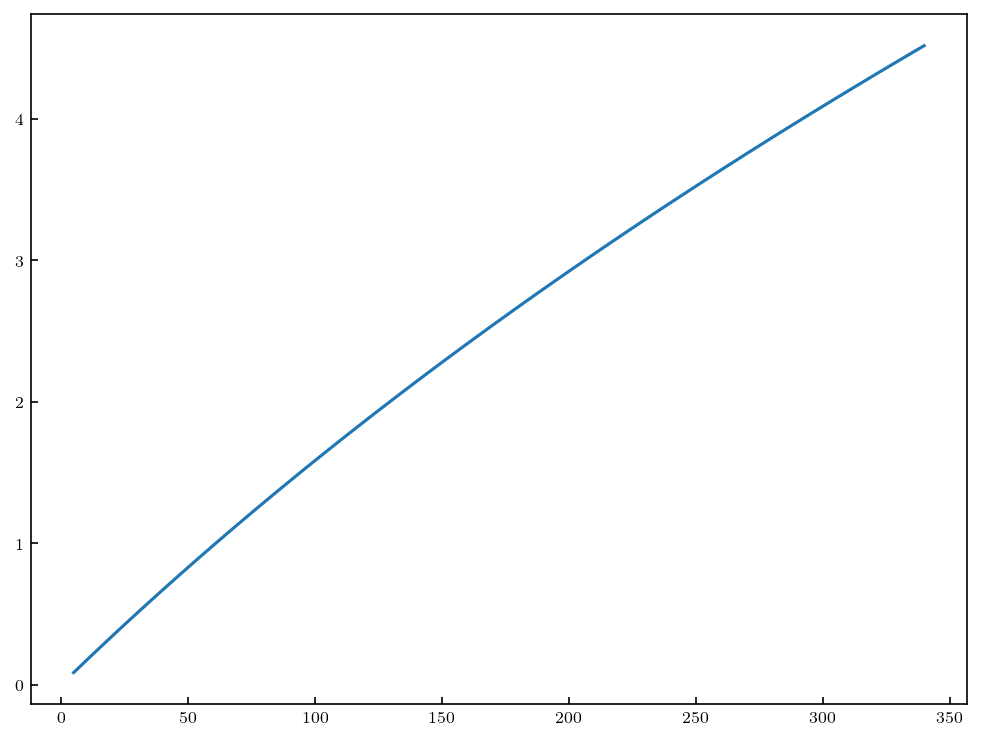

In [8]:
from compton import momentum_transfer_cm, omega_cm_from_lab, mass_proton
q_cm_test = momentum_transfer_cm(omega_cm_from_lab(omega, mass=mass_proton), np.cos(np.deg2rad(1)))
plt.plot(omega, q_cm_test)

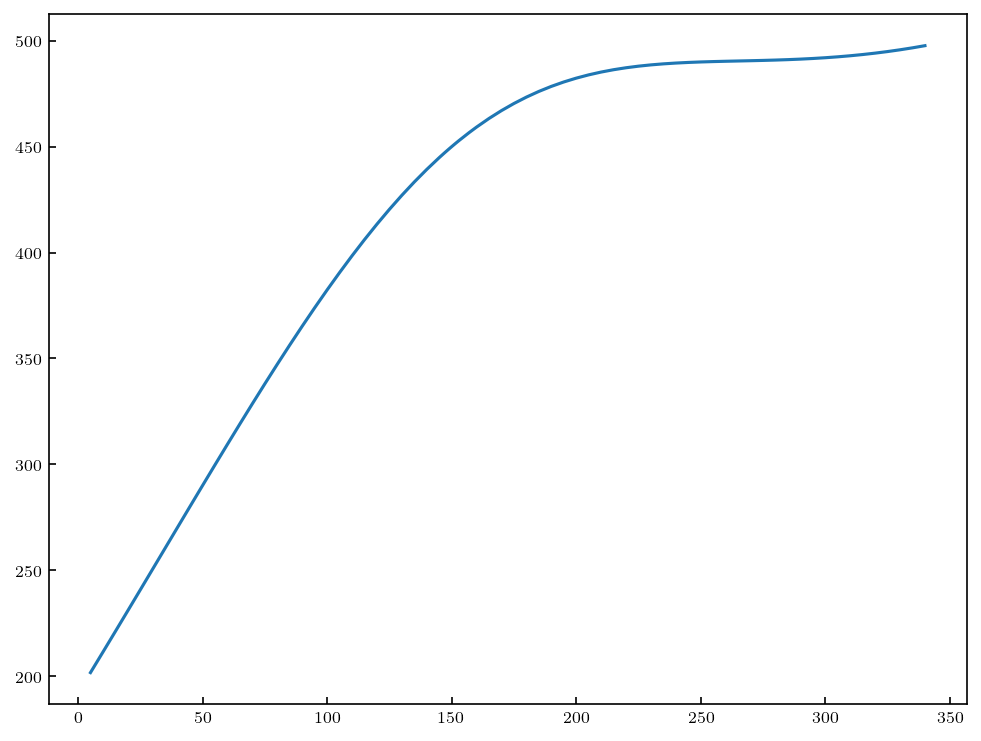

In [9]:
# fwhm = 100
# lorentz = 3000 * fwhm / ((omega - 150)**2 + (0.5 * fwhm)**2)

height = 300
omega_width = 200
cos0_width = 1
lorentz = height / (
        ((omega - 150) / omega_width) ** 2 + 1
)

plt.plot(omega, omega + lorentz)

In [10]:
omega

array([  5.       ,  10.       ,  15.       ,  20.       ,  25.       ,
        30.       ,  35.       ,  40.       ,  45.       ,  50.       ,
        55.       ,  60.       ,  65.       ,  70.       ,  75.       ,
        80.       ,  85.       ,  90.       ,  95.       , 100.       ,
       105.       , 110.       , 115.       , 120.       , 125.       ,
       130.       , 135.       , 140.       , 145.       , 147.       ,
       148.       , 149.       , 149.9506926, 151.       , 152.       ,
       153.       , 157.       , 160.       , 165.       , 170.       ,
       175.       , 180.       , 185.       , 190.       , 195.       ,
       200.       , 205.       , 210.       , 215.       , 220.       ,
       225.       , 230.       , 235.       , 240.       , 245.       ,
       250.       , 255.       , 260.       , 265.       , 270.       ,
       275.       , 280.       , 285.       , 290.       , 295.       ,
       300.       , 305.       , 310.       , 315.       , 320. 

In [11]:
omega.shape

(74,)

In [12]:
Lambdab = 600

# R_script = (mass_delta - mass_proton) / Lambdab
# delta_omega = df['omegalab [MeV]'] / Lambdab
# Q_vals_phillips = np.vstack([
#     np.ones_like(delta_omega),
#     delta_omega ** 1 * R_script,
#     delta_omega ** 2 * R_script,
#     delta_omega ** 3 * R_script ** 2 * (mass_delta - mass_proton) / mass_pion,
#     delta_omega ** 3 * R_script ** 2
# ])

In [14]:
mass_delta - mass_proton

293.72799999999995

In [15]:
mass_pion / mass_delta

0.11201298701298701

In [16]:
mass_delta / Lambdab

2.0533333333333332

In [17]:
np.sqrt(mass_pion * Lambdab)

287.74989139876317

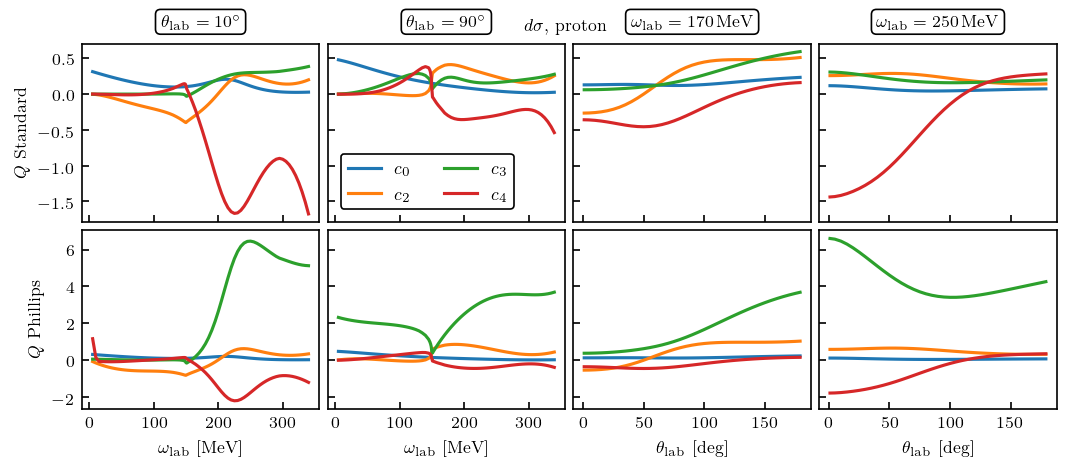

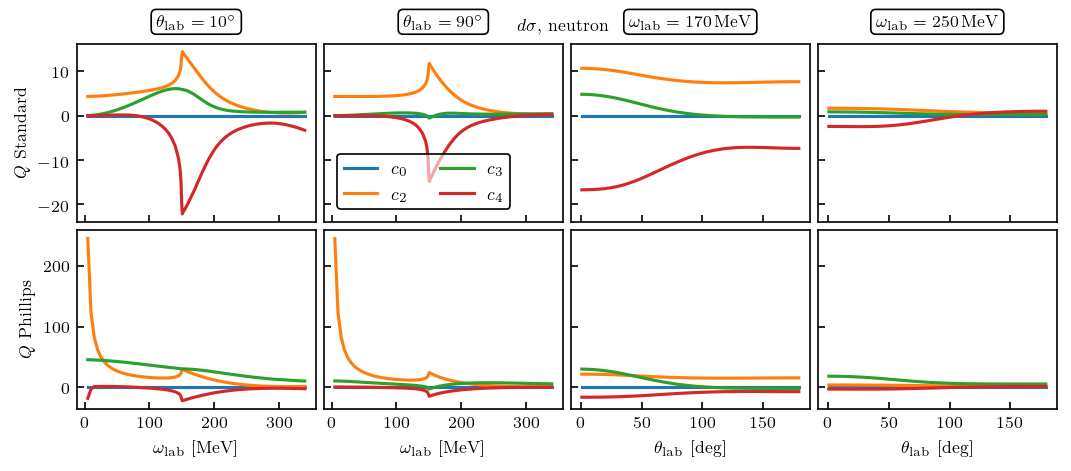

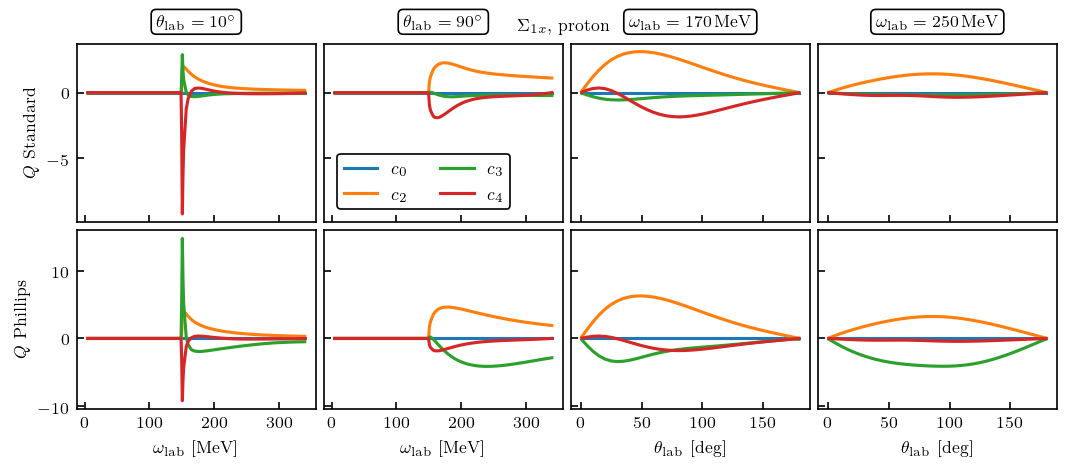

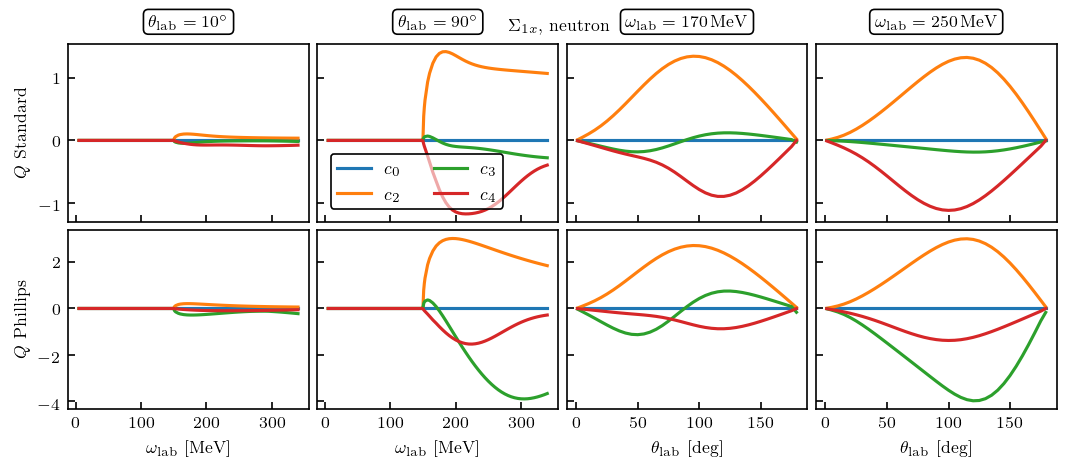

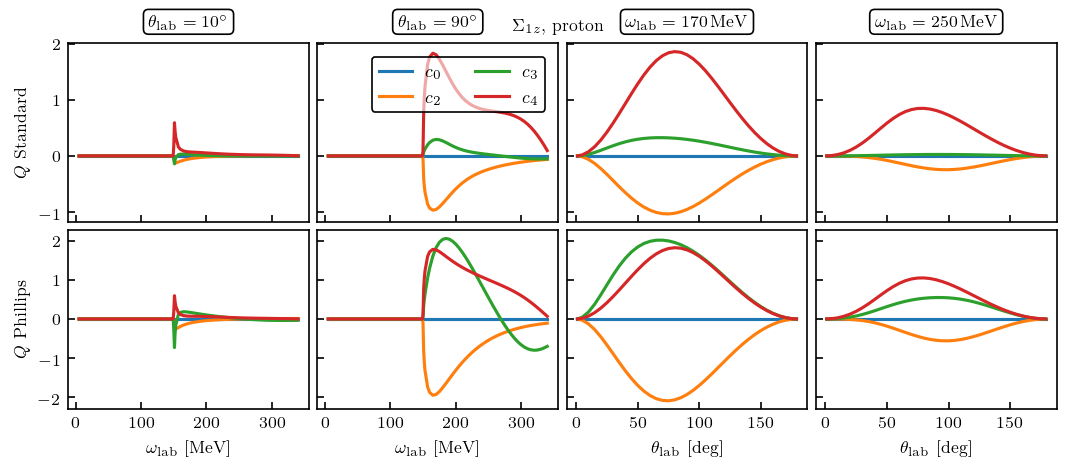

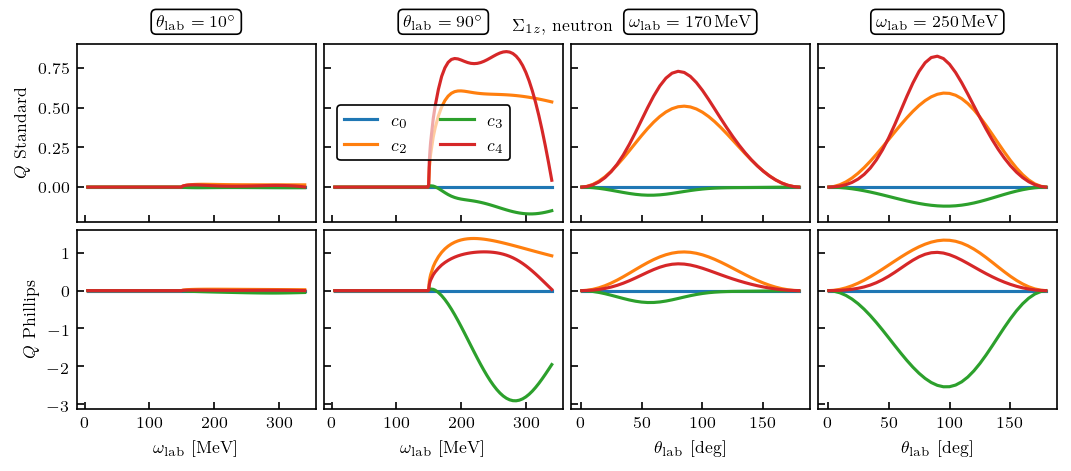

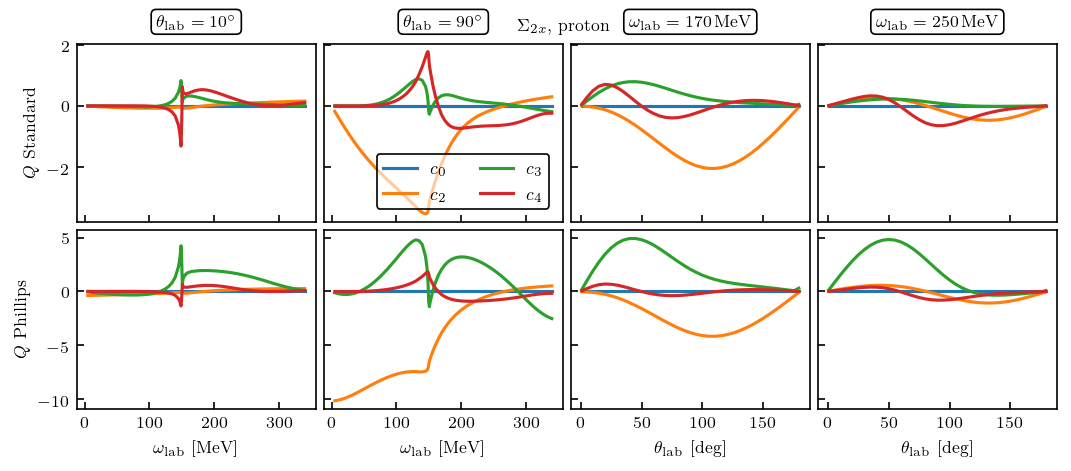

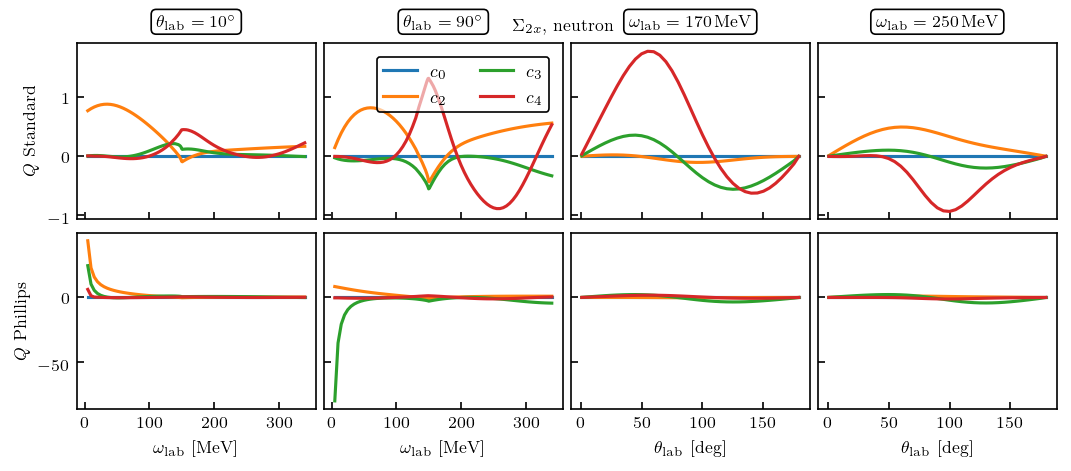

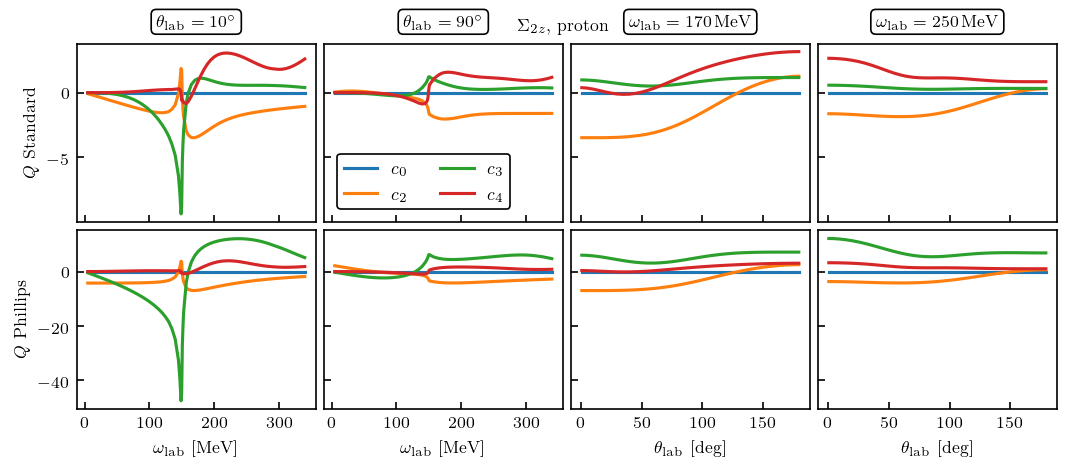

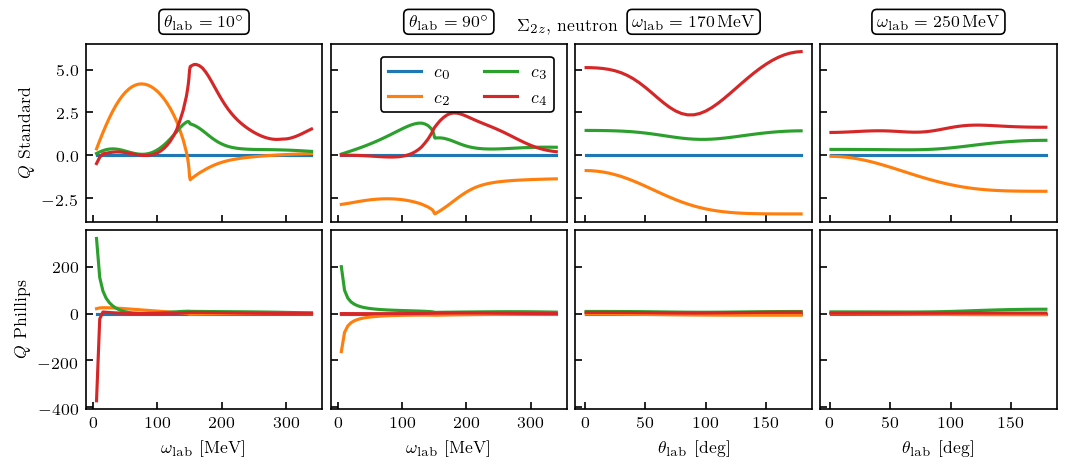

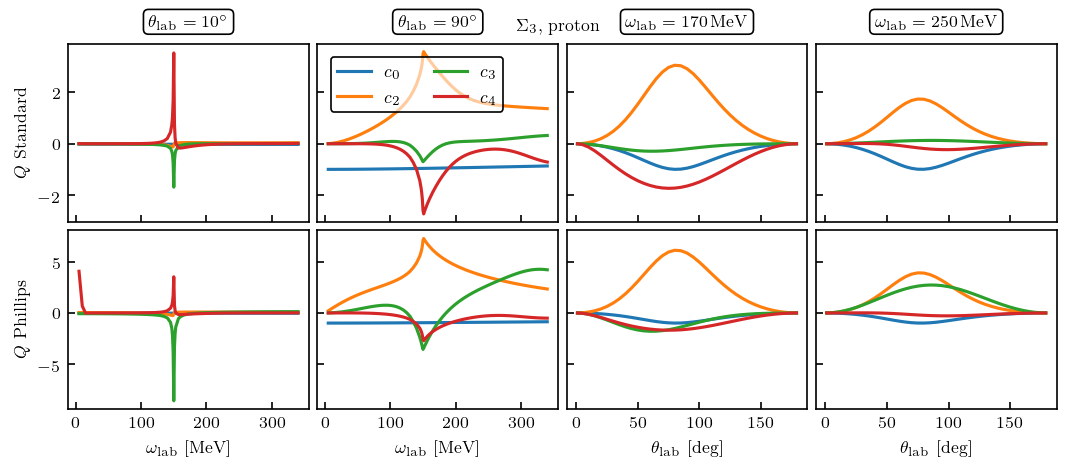

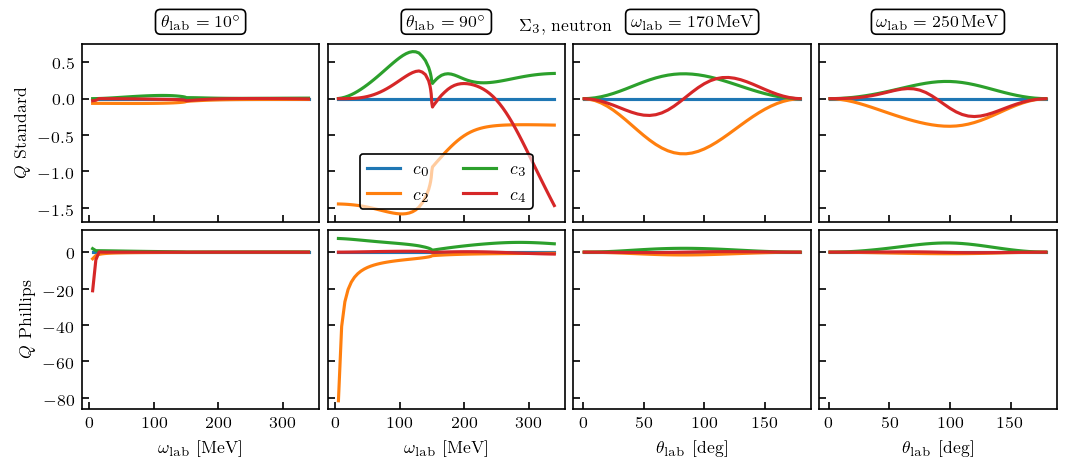

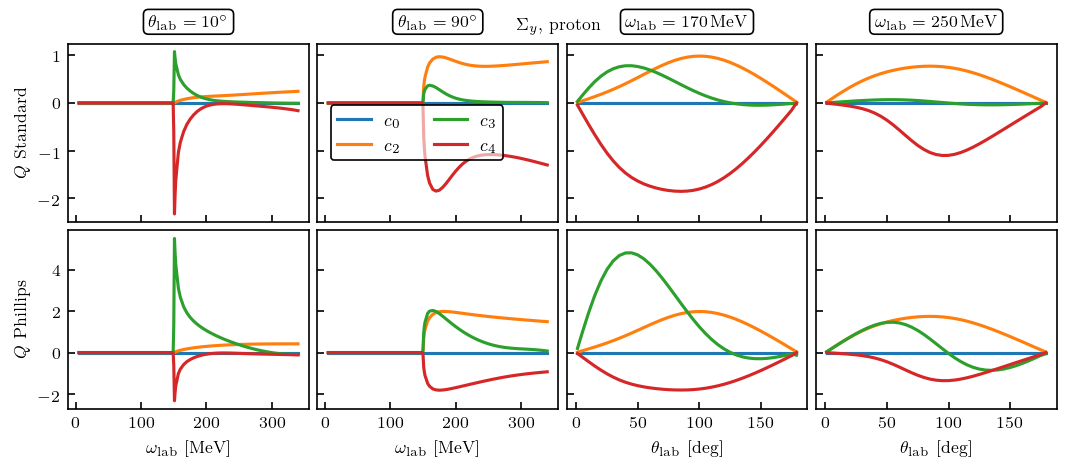

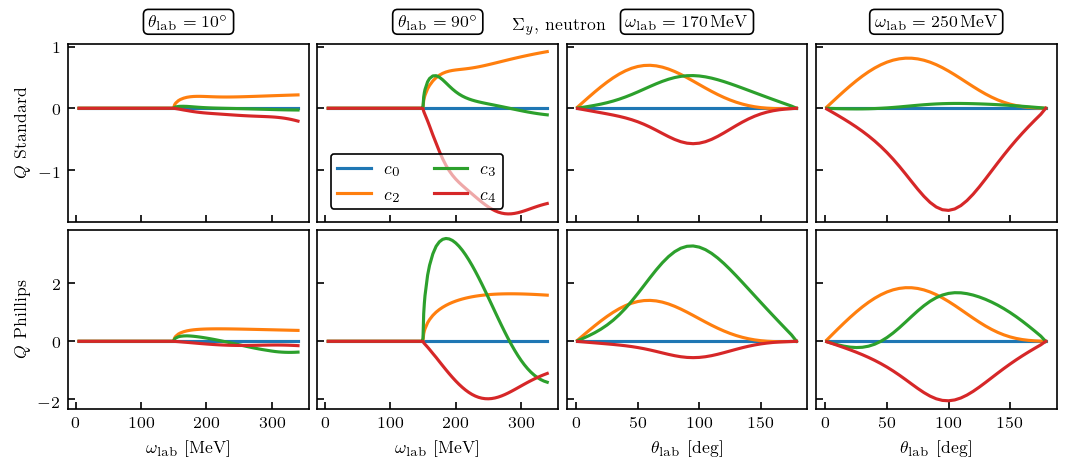

In [ ]:
omega_plot = 170
theta_plot = 10

omega_plot2 = 250
theta_plot2 = 90
# system = 'proton'

from itertools import product
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    for obs, system in product(observables_unique, ['proton', 'neutron']):
        obs_no_tex = observables_name_inverse_map[obs]
        height = kernel_kwargs[obs_no_tex, system]['height']
        width = 150 if obs == dsg_label else 50
        width_degrees = 90 if obs == dsg_label else np.inf
        df_i = df[(df['observable'] == obs) & (df['nucleon'] == system)]
        X = df_i[['omegalab [MeV]', 'thetalab [deg]']].values
        y = df_i[['y0', 'y2', 'y3', 'y4']].values
        
        ref = 1.
        if obs == dsg_label:
#             ref = df_i['y4'].values
            ref = df_dsg_ref['ref'][df_dsg_ref['nucleon'] == system].values
#             ref = df_i['y4'].values
        
        if obs != dsg_label:
            df_dsg = df[(df['observable'] == dsg_label) & (df['nucleon'] == system)]
            ref_dsg = df_dsg_ref['ref'][df_dsg_ref['nucleon'] == system].values
            y2 = y * df_dsg[['y0', 'y2', 'y3', 'y4']].values
            ref2 = ref_dsg
#             ref2 = 1.
#             ref2 = df_dsg['y4'].values
#             ref2 = ref_dsg / df_dsg['y4'].values
        else:
            y2 = y
            ref2 = ref

        y_grid = y.reshape(len(omega), len(theta), -1)
        y2_grid = y2.reshape(len(omega), len(theta), -1)

#         if system == 'proton':
#             ref2 = ref * ref_scale(X[:, 0], omega_lab_cusp, X[:, 1], height=height, width=width, degrees_width=width_degrees)
#         else:
#             ref2 = ref
        if system == 'proton' and obs == dsg_label:
            dsg_scale_lorentz = ref_scale(X[:, 0], omega_lab_cusp, X[:, 1], height=height, width=width, degrees_width=width_degrees)
            ref *= dsg_scale_lorentz
            ref2 *= dsg_scale_lorentz
        else:
            pass

        mass = mass_proton if system == 'proton' else mass_neutron
#         Q = expansion_parameter_transfer_cm(X, Lambdab, mass, include_correction=False)
#         Q = expansion_parameter_transfer_cm(X, Lambdab, mass, include_correction=True)
#         Q2 = expansion_parameter_phillips(Lambdab)
        Q = expansion_parameter_phillips(Lambdab)
#         Q = omega_cm_from_lab(X[:, 0], mass) / Lambdab
        ord_vals = np.array([order_transition(order, order_map[order], X[:, 0]) for order in orders]).T
    #     ord_vals = orders
    
    
        R_script = (mass_delta - mass_proton) / Lambdab
#         delta_omega = (X[:, 0] + mass_pion) / Lambdab
        delta_omega = (X[:, 0] + 0*mass_pion) / Lambdab
        Q_vals_phillips = np.vstack([
            np.ones_like(delta_omega),
            delta_omega ** 1 * R_script,
            delta_omega ** 2 * R_script,
            delta_omega ** 2,
#             delta_omega ** 3 * R_script ** 2 * (mass_delta - mass_proton) / mass_pion,
#             delta_omega ** 3 * R_script ** 2
        ])

        coeffs = coefficients(y, ratio=Q, orders=ord_vals, ref=ref)
    #     coeffs2 = coefficients(y, ratio=Q, orders=ord_vals, ref=ref2)
#         coeffs2 = coefficients(y, ratio=Q2, orders=ord_vals, ref=ref)
#         coeffs2 = coefficients(y2, ratio=Q, orders=ord_vals, ref=ref2)

        coeffs2 = np.diff(y, prepend=0) / Q_vals_phillips.T / np.atleast_1d(ref)[:, None]
        coeffs_grid = coeffs.reshape(len(omega), len(theta), -1)
        coeffs_grid2 = coeffs2.reshape(len(omega), len(theta), -1)

#         if obs == dsg_label and system == 'proton':
#             fig, axes = plt.subplots(3, 4, figsize=(7, 4), sharex='col', sharey='row')
#             coeffs3 = coefficients(y, ratio=Q2, orders=ord_vals, ref=ref2)
#             coeffs_grid3 = coeffs3.reshape(len(omega), len(theta), -1)
#         else:
#             fig, axes = plt.subplots(2, 4, figsize=(7, 3), sharex='col', sharey='row')
        fig, axes = plt.subplots(2, 4, figsize=(7, 3), sharex='col', sharey='row')

        for i, n in enumerate(orders):
            label = fr'$c_{n}$'
            o_mask = slice(0, None)
            axes[0, 0].plot(omega[o_mask], np.squeeze(coeffs_grid[o_mask, theta == theta_plot][..., i]), label=label)
            axes[1, 0].plot(omega[o_mask], np.squeeze(coeffs_grid2[o_mask, theta == theta_plot][..., i]), label=label)
            axes[0, 1].plot(omega[o_mask], np.squeeze(coeffs_grid[o_mask, theta == theta_plot2][..., i]), label=label)
            axes[1, 1].plot(omega[o_mask], np.squeeze(coeffs_grid2[o_mask, theta == theta_plot2][..., i]), label=label)

            axes[0, 2].plot(theta, np.squeeze(coeffs_grid[omega == omega_plot][..., i]), label=label)
            axes[1, 2].plot(theta, np.squeeze(coeffs_grid2[omega == omega_plot][..., i]), label=label)
            axes[0, 3].plot(theta, np.squeeze(coeffs_grid[omega == omega_plot2][..., i]), label=label)
            axes[1, 3].plot(theta, np.squeeze(coeffs_grid2[omega == omega_plot2][..., i]), label=label)

#             if obs == dsg_label and system == 'proton':
#                 axes[2, 0].plot(omega, np.squeeze(coeffs_grid3[:, theta == theta_plot][..., i]), label=label)
#                 axes[2, 1].plot(omega, np.squeeze(coeffs_grid3[:, theta == theta_plot2][..., i]), label=label)
#                 axes[2, 2].plot(theta, np.squeeze(coeffs_grid3[omega == omega_plot][..., i]), label=label)
#                 axes[2, 3].plot(theta, np.squeeze(coeffs_grid3[omega == omega_plot2][..., i]), label=label)

        bbox = dict(facecolor='w', boxstyle='round', alpha=1)
#         xlabel_idx = 2 if obs == dsg_label and system == 'proton' else 1
        xlabel_idx = 1
        for ii, ax_col in enumerate(axes.T):
            if ii < 2:
    #             for ax in ax_col[:1]:
                if ii == 0:
                    tp = theta_plot
                else:
                    tp = theta_plot2
                ax_col[0].text(
                    0.5, 1.08, fr'$\theta_{{\rm lab}}={tp}^\circ$', bbox=bbox,
                    transform=ax_col[0].transAxes, ha='center', va='bottom'
                )
                ax_col[xlabel_idx].set_xlabel(r'$\omega_{\rm lab}$ [MeV]')
            else:
    #             for ax in ax_col[:1]:
                if ii == 2:
                    op = omega_plot
                else:
                    op = omega_plot2
                ax_col[0].text(
                    0.5, 1.08, fr'$\omega_{{\rm lab}}={op}$\,MeV', bbox=bbox,
                    transform=ax_col[0].transAxes, ha='center', va='bottom'
                )
                ax_col[xlabel_idx].set_xlabel(r'$\theta_{\rm lab}$ [deg]')

    #     axes[0, 0].text(
    #         0.05, 0.95, fr'$\theta={theta_plot}^\circ$', bbox=bbox,
    #         transform=axes[0, 0].transAxes, ha='left', va='top'
    #     )
    #     axes[1, 0].text(
    #         0.05, 0.95, fr'$\theta={theta_plot}^\circ$', bbox=bbox,
    #         transform=axes[1, 0].transAxes, ha='left', va='top'
    #     )
    #     axes[0, 1].text(
    #         0.05, 0.95, fr'$\omega={omega_plot}$', bbox=bbox,
    #         transform=axes[0, 1].transAxes, ha='left', va='top'
    #     )
    #     axes[1, 1].text(
    #         0.05, 0.95, fr'$\omega={omega_plot}$', bbox=bbox,
    #         transform=axes[1, 1].transAxes, ha='left', va='top'
    #     )
    
#         axes[0, 0].set_ylabel(r'$Q \sim p + m_\pi$')
#         axes[0, 0].set_ylabel(r'$Q = (\omega + m_\pi) / \Lambda_b$')
# #         axes[1, 0].set_ylabel(r'$Q_L = Q + {\rm Lorentz}$')
#         axes[1, 0].set_ylabel(r'$Q = \sqrt{m_\pi / \Lambda_b}$')
#         if obs == dsg_label and system == 'proton':
#             axes[2, 0].set_ylabel(r'$Q_{L} \&\,y_{\rm ref}$ Lorentz')

#         axes[0, 0].set_ylabel(r'$Q = (\omega + m_\pi) / \Lambda_b$')
#         axes[1, 0].set_ylabel(r'$Q = \sqrt{m_\pi / \Lambda_b}$')
#         axes[0, 0].set_ylabel(r'$(\Delta y) / Q^n$')
#         axes[1, 0].set_ylabel(r'$\Delta (y * d\sigma) / (y_{\mathrm{ref}} Q^n)$')
        axes[0, 0].set_ylabel(r'$Q$ Standard')
        axes[1, 0].set_ylabel(r'$Q$ Phillips')

        axes[0, 1].legend(ncol=2)

    #     axes[1, 0].set_xlabel(r'$\omega_{\rm lab}$ [MeV]')
    #     axes[1, 1].set_xlabel(r'$\theta_{\rm lab}$ [deg]')
#         y_title = 0.92 if obs != dsg_label else 0.945
        fig.suptitle(x=1, y=1.05, t=f'{obs}, {system}', transform=axes[0, 1].transAxes, va='bottom', ha='center')
#         fig.tight_layout(w_pad=-0.1, h_pad=0.3)
        plt.show()
        fig.savefig(f'coefficient_figures/coeffs_{obs_no_tex}_{system}')
    #     break

In [ ]:
from compton import order_transition


# Fourth order is complete at low energy, so omitted is 5
# But it is not complete at high energy, so it goes to 1
omitted_order = order_transition(5, 1, omega)

In [ ]:
Q_no_correction = expansion_parameter_transfer_cm(X, Lambdab, mass_proton, include_correction=False)
Q_correction = expansion_parameter_transfer_cm(X, Lambdab, mass_proton, include_correction=True)

Q_no_correction_mat = Q_no_correction.reshape(len(omega), len(theta))
Q_correction_mat = Q_correction.reshape(len(omega), len(theta))

# Q_no_correction_sum_mat = compute_expansion_summation_matrix(Q_no_correction, omitted_order)
# Q_correction_sum_mat = compute_expansion_summation_matrix(Q_correction, omitted_order)

# Do not include correlations
Q_no_correction_sum_mat = Q_no_correction_mat ** omitted_order[:, None] / np.sqrt(1 - Q_no_correction_mat**2)
Q_correction_sum_mat = Q_correction_mat ** omitted_order[:, None] / np.sqrt(1 - Q_correction_mat**2)

In [ ]:
Q_no_correction_sum_mat.shape

In [ ]:
Q_no_correction.max()

In [ ]:
Q_contours = np.linspace(0, 1, 11)

cmap_Q = 'GnBu'

fig, axes = plt.subplots(1, 2, figsize=(7, 3.4), sharex=True, sharey=True)
axes[0].contourf(omega, theta, Q_no_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)
CS = axes[0].contour(omega, theta, Q_no_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)

axes[1].contourf(omega, theta, Q_no_correction_sum_mat.T, cmap=cmap_Q)
CS2 = axes[1].contour(omega, theta, Q_no_correction_sum_mat.T, cmap=cmap_Q)

axes[0].clabel(CS, Q_contours, inline=True, colors='k')
axes[1].clabel(CS2, inline=True, colors='k')
axes[0].set_title('Expansion Parameter $Q$')
axes[0].set_ylabel(r'$\theta_{\rm lab}$ [deg]')
axes[1].set_title(r'Std. Dev. Factor: $Q^{\nu} / \sqrt{1 - Q^2}$')
for ax in axes.ravel():
    ax.set_xlabel(r'$\omega_{\rm lab}$ [MeV]')

fig.tight_layout()

In [ ]:
0.7**2 / (1 - 0.7**2)

In [ ]:
Q_contours = np.linspace(0, 1, 11)

fig, axes = plt.subplots(1, 2, figsize=(7, 3.4), sharex=True, sharey=True)
axes[0].contourf(omega, theta, Q_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)
CS = axes[0].contour(omega, theta, Q_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)
axes[1].contourf(omega, theta, Q_correction_sum_mat.T, cmap=cmap_Q)
CS2 = axes[1].contour(omega, theta, Q_correction_sum_mat.T, cmap=cmap_Q)

# axes[0].clabel(CS, Q_contours, inline=True, colors='k')
axes[0].clabel(CS, inline=True, colors='k')
axes[1].clabel(CS2, inline=True, colors='k')
axes[0].set_title('Expansion Parameter $Q$')
axes[0].set_ylabel(r'$\theta_{\rm lab}$ [deg]')
axes[1].set_title(r'Std. Dev. Factor: $Q^{\nu} / \sqrt{1 - Q^2}$')
for ax in axes.ravel():
    ax.set_xlabel(r'$\omega_{\rm lab}$ [MeV]')
# plt.clabel()
fig.tight_layout()
fig.savefig('expansion_parameter_with_lorentz')